In [1]:
%matplotlib inline

import numpy as np # Linear algebra
import pandas as pd # Data processing, read CSV file
import random
from timeit import default_timer as timer
import progressbar as pb

from PIL import Image

import os

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms
from skimage.transform import resize
import copy

os.listdir('./input/')

['.DS_Store', 'test', 'train', 'train.csv', 'sample_submission.csv']

# Helper code

In [2]:
# Target labels
LABEL_MAP = {
    0: "Nucleoplasm",
    1: "Nuclear membrane",
    2: "Nucleoli",
    3: "Nucleoli fibrillar center",   
    4: "Nuclear speckles",
    5: "Nuclear bodies",
    6: "Endoplasmic reticulum",
    7: "Golgi apparatus",
    8: "Peroxisomes",
    9:  "Endosomes",
    10: "Lysosomes",
    11: "Intermediate filaments", 
    12: "Actin filaments",
    13: "Focal adhesion sites",
    14: "Microtubules",
    15: "Microtubule ends",
    16: "Cytokinetic bridge",
    17: "Mitotic spindle",
    18: "Microtubule organizing center",  
    19: "Centrosome",
    20: "Lipid droplets",
    21: "Plasma membrane",
    22: "Cell junctions",
    23: "Mitochondria",
    24: "Aggresome",
    25: "Cytosol",
    26: "Cytoplasmic bodies",
    27: "Rods & rings"
}

# Defines
DIM_HEIGHT = DIM_WIDTH = 512
NUM_CHANNELS = 4
NUM_CLASSES = 28
IMAGE_SIZE = (120, 120) # change to desired dimension


class ETATimer():
    '''
    ETA estimation of code execution
    
    Args
        n_iter: Number of iterations in code execution
        description: Description of ETA timer visualization
    '''
    
    def __init__(self, n_iter, description):
        self.n_iter         = n_iter
        self.iter           = 0
        self.description    = description + ': '
        self.timer          = None
        self.initialize()

    def initialize(self):
        #initialize timer
        widgets = [self.description, pb.Percentage(), ' ',   
                   pb.Bar(), ' ', pb.ETA()]
        self.timer = pb.ProgressBar(widgets=widgets, max_value=n_iter).start()

    def update(self, q=1):
        #update timer
        self.timer.update(self.iter)
        self.iter += q

    def finish(self):
        #end timer
        self.timer.finish()

# Create Dataset

In [3]:
class HumanProteinDataset(Dataset):
    
    def __init__(self, path_to_csv, transform=True, test=False):
        """
        Construct Human Protein Dataset.
        
        Args
            path_to_csv: 
                Path to csv file
            transform:
                Transform data to torch Tensors and normalize image pixel values. (Default: True)
            test:
                If True constructs test dataset. (Default: False)
        """
        self.transform = transform
        self.test = test
        
        # create dataframe from CSV file
        self.df = pd.read_csv(path_to_csv)
        
        if not self.test:
            # modify dataframe with columns representing all classes and map corresponding target values (1 or 0)
            for n in range(len(LABEL_MAP)):
                self.df[f'{LABEL_MAP.get(n)}'] = self.df['Target'].map(
                lambda x: 1 if str(n) in x.strip().split() else 0)
        
        if not self.test:
            self.path = './input/train/'
        else:
            self.path = './input/test/'
            
        
    def __getitem__(self, idx):
        """
        Support integer indexing on dataset (range 0 to len(self)).
        """
        
        Id = self.df['Id'].iloc[idx]
        Targets = np.zeros(len(LABEL_MAP))
        
        if not self.test:
            for i, label in enumerate(LABEL_MAP.values()):
                if self.df[label].iloc[idx] == 1:
                    Targets[i] = 1
            
        images = np.zeros(shape=(DIM_HEIGHT, DIM_WIDTH, NUM_CHANNELS))
        images[:,:,0] = np.asarray(Image.open(self.path + Id + "_red" + ".png"))
        images[:,:,1] = np.asarray(Image.open(self.path + Id + "_green" + ".png"))
        images[:,:,2] = np.asarray(Image.open(self.path + Id + "_blue" + ".png"))
        images[:,:,3] = np.asarray(Image.open(self.path + Id + "_yellow" + ".png"))
        
        sample = {'Id': Id, 'Targets': Targets, 'Images':images}
        
        if self.transform:
            # normalize pixel values in image from [0, 255] to [0, 1]
            images = sample['Images']
            images_normalized = np.copy(images)
            images_normalized /= 255.
            
            # resize images to specified IMAGE_SIZE
            images_resized = resize(images_normalized, output_shape=IMAGE_SIZE, mode='reflect', anti_aliasing=True)
            
            # convert from numpy array to torch Tensor
            sample = {'Id': Id, \
                      'Targets': torch.from_numpy(Targets), \
                      'Images': torch.from_numpy(images_normalized), \
                      'Images_resized': torch.from_numpy(images_resized)}
            

        return sample
    
    def __len__(self):
        """
        Get length of dataset.
        """
        return len(self.df)

In [4]:
dataset = HumanProteinDataset('./input/train.csv', transform=True)
dataset.df.head()

Id   Target  Nucleoplasm  \
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0            1   
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0            1   
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5            0   
3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1            0   
4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18            0   

   Nuclear membrane  Nucleoli  Nucleoli fibrillar center  Nuclear speckles  \
0                 0         0                          0                 0   
1                 1         1                          0                 0   
2                 0         0                          0                 0   
3                 1         0                          0                 0   
4                 0         0                          0                 0   

   Nuclear bodies  Endoplasmic reticulum  Golgi apparatus      ...       \
0               0                      0                0      ...        
1               0                      0                1      ...        
2               1                      0                0      ...        
3               0                      0                0      ...        
4               0                      0                0      ...        

   Microtubule organizing center  Centrosome  Lipid droplets  Plasma membrane  \
0                              0           0               0                0   
1                              0           0               0                0   
2                              0           0               0                0   
3                              0           0               0                0   
4                              1           0               0                0   

   Cell junctions  Mitochondria  Aggresome  Cytosol  Cytoplasmic bodies  \
0               0             0          0        0                   0   
1               0             0          0        0                   0   
2               0             0          0        0                   0   
3               0             0          0        0                   0   
4               0             0          0        0                   0   

   Rods & rings  
0             0  
1             0  
2             0  
3             0  
4             0  

[5 rows x 30 columns]

# Show Images from Samples
Next I'm going to visualize the data images.

10266 torch.Size([512, 512, 4])
22003 torch.Size([512, 512, 4])
20746 torch.Size([512, 512, 4])
11980 torch.Size([512, 512, 4])
6579 torch.Size([512, 512, 4])


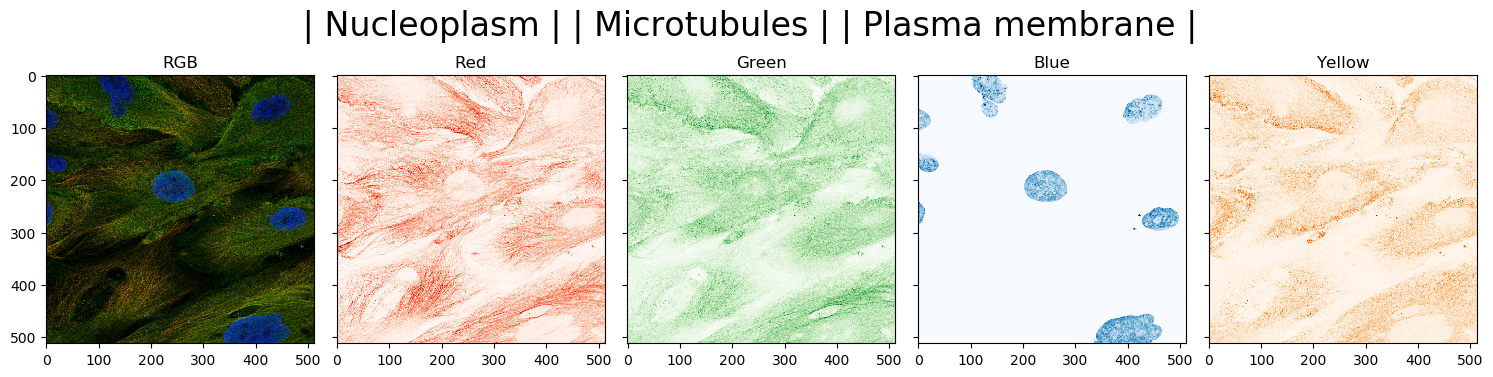

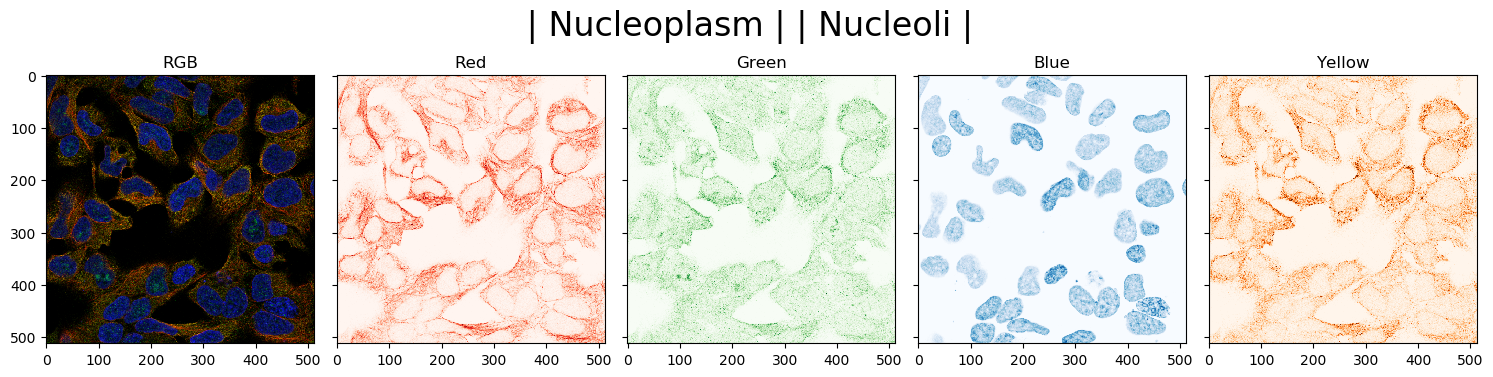

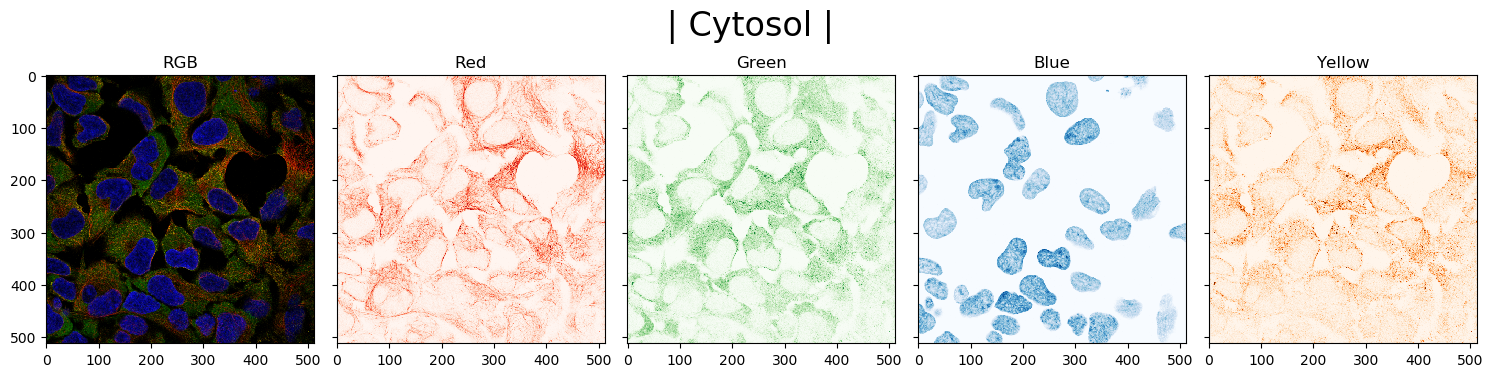

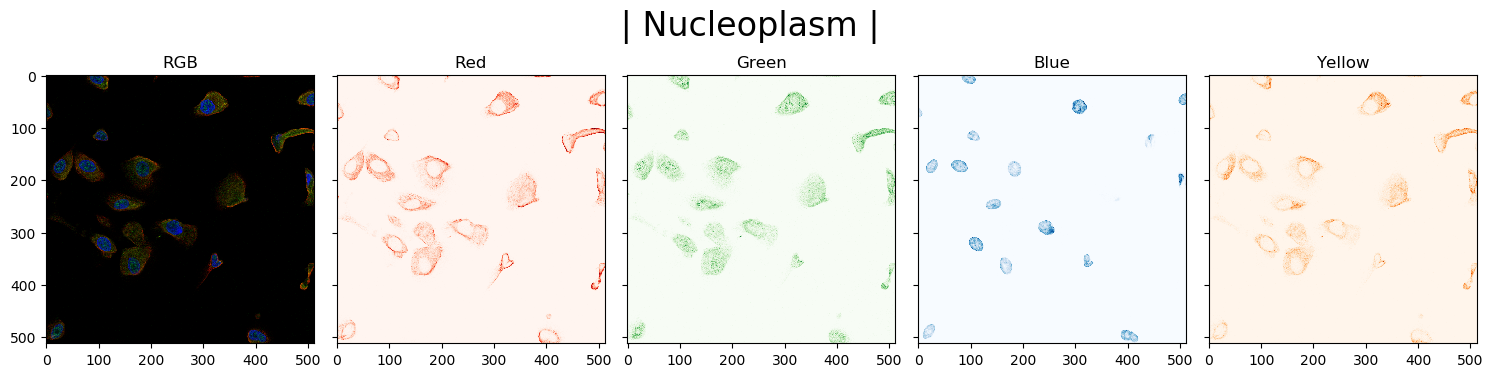

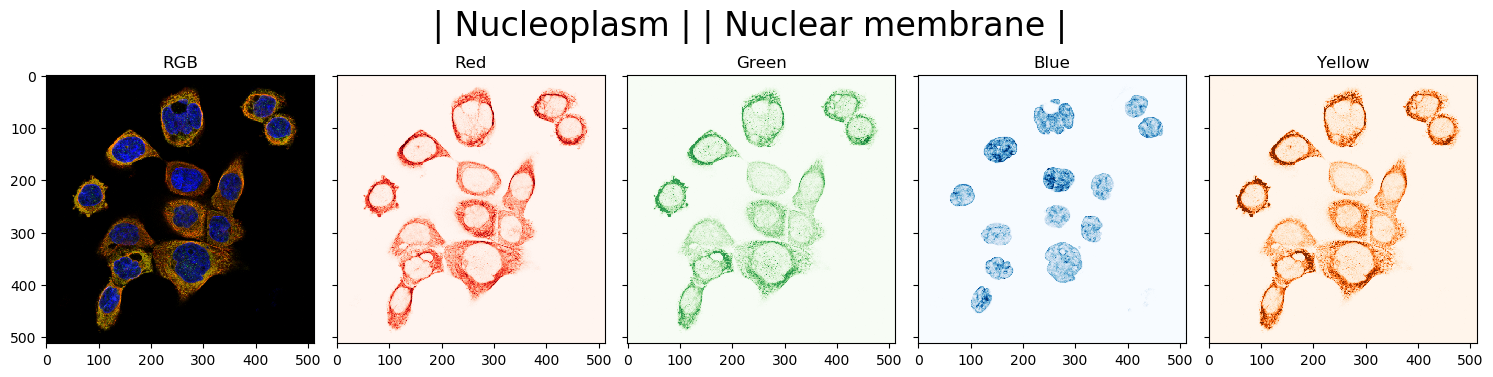

In [5]:
def show_images(sample):
    """
    Displays images for a specific ID in the colors red, green, blue, yellow and RGB.
    """
    cols = 4
    rows = 3
    title = ''
    
    # title is target labels in sample
    labels = []
    for label in LABEL_MAP.values():
        labels.append(label)
    
    for Id, label in enumerate(labels):
        if sample['Targets'][Id] == 1:
            title += ' | ' + label + ' |'
    
    mpl.style.use('default')
    fig, axs = plt.subplots(1, 5, figsize=(15,10), sharey=True)
    
    # construct RGB image
    # exclude yellow
    RGB = sample['Images'][:,:,:-1]
    # add yellow color to RGB
    # yellow is composed of red+green -> blue has yellow, add yellow only to red and green
    RGB[:,:,0] += sample['Images'][:,:,3]
    RGB[:,:,1] += sample['Images'][:,:,3]
    # normalize red and green colors again
    RGB[:,:,0] /= 2
    RGB[:,:,1] /= 2
    
    # plot images
    axs[0].imshow(RGB)
    axs[0].set_title('RGB')
    axs[1].imshow(sample['Images'][:,:,0], cmap="Reds")
    axs[1].set_title('Red')
    axs[2].imshow(sample['Images'][:,:,1], cmap='Greens')
    axs[2].set_title('Green')
    axs[3].imshow(sample['Images'][:,:,2], cmap="Blues")
    axs[3].set_title('Blue')
    axs[4].imshow(sample['Images'][:,:,3], cmap="Oranges")
    axs[4].set_title('Yellow')
    fig.suptitle(title, fontsize=24, y=0.7)
    plt.tight_layout()
    
idx = random.sample(range(1, dataset.df.shape[0]), k=5)

for i in idx:
    show_images(dataset[i])
    print(i, dataset[i]['Images'].shape)

## Insights
From the first print statements, we can see that from random sampling 5 samples from the dataset, that the dimensions of the images are the same. This means we don't have to rescale the images to matching sizes for the network.

# Resizing images for faster training

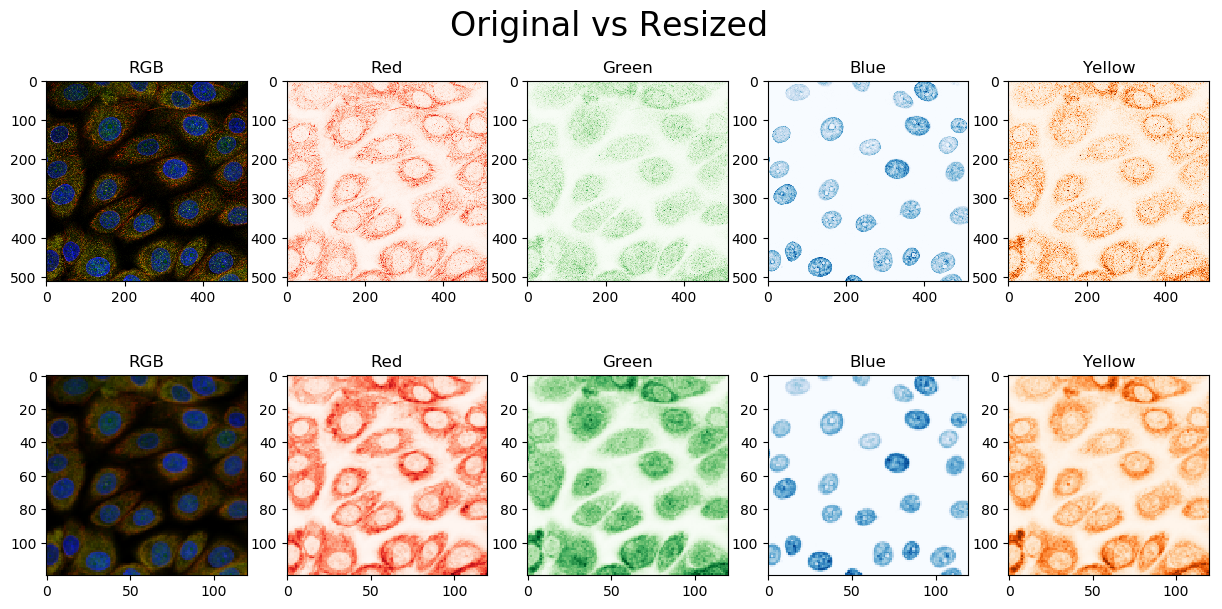

In [6]:
def show_resized_images(sample):
    images = sample['Images'].numpy()
    images_resized = sample['Images_resized'].numpy()
    
    # construct RGB image
    # exclude yellow
    rgb = images[:,:,:-1]
    rgb_resized = images_resized[:,:,:-1]
    # add yellow color to RGB
    # yellow is composed of red+green -> blue has yellow, add yellow only to red and green
    rgb[:,:,0] += images[:,:,3]
    rgb[:,:,1] += images[:,:,3]
    rgb_resized[:,:,0] += images_resized[:,:,3]
    rgb_resized[:,:,1] += images_resized[:,:,3]
    # normalize red and green colors again
    rgb[:,:,0] /= 2
    rgb[:,:,1] /= 2
    rgb_resized[:,:,0] /= 2
    rgb_resized[:,:,1] /= 2
    
    mpl.style.use('default')
    fig, axs = plt.subplots(2, 5, figsize=(15, 7))
    
    # plot original images
    axs[0,0].imshow(rgb)
    axs[0,0].set_title('RGB')
    axs[0,1].imshow(images[:,:,0], cmap="Reds")
    axs[0,1].set_title('Red')
    axs[0,2].imshow(images[:,:,1], cmap='Greens')
    axs[0,2].set_title('Green')
    axs[0,3].imshow(images[:,:,2], cmap="Blues")
    axs[0,3].set_title('Blue')
    axs[0,4].imshow(images[:,:,3], cmap="Oranges")
    axs[0,4].set_title('Yellow')
    # plot resized images
    axs[1,0].imshow(rgb_resized)
    axs[1,0].set_title('RGB')
    axs[1,1].imshow(images_resized[:,:,0], cmap="Reds")
    axs[1,1].set_title('Red')
    axs[1,2].imshow(images_resized[:,:,1], cmap='Greens')
    axs[1,2].set_title('Green')
    axs[1,3].imshow(images_resized[:,:,2], cmap="Blues")
    axs[1,3].set_title('Blue')
    axs[1,4].imshow(images_resized[:,:,3], cmap="Oranges")
    axs[1,4].set_title('Yellow')
    fig.suptitle('Original vs Resized', fontsize=24, y=0.95)
    plt.show();
    
show_resized_images(dataset[1500])

## Insights
By resizing the images we might lose valuable information as seen in the resolution difference in the original images and the resized images.

# Most Occuring Target in Dataset

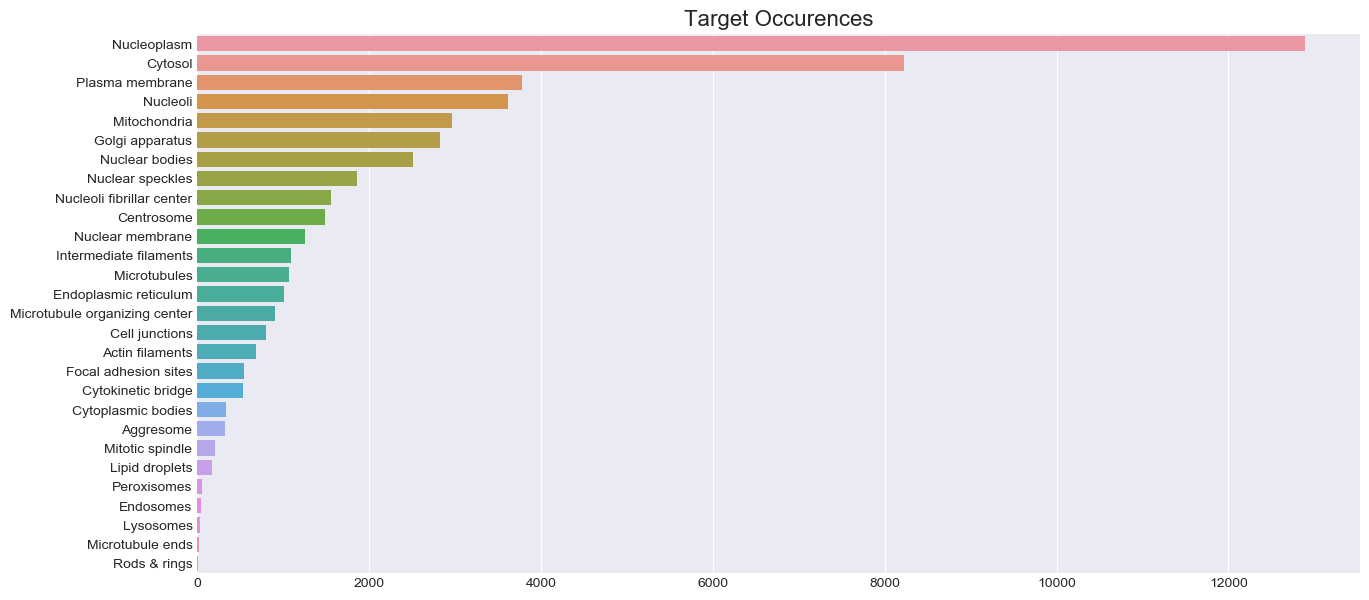

In [7]:
# get total for each target label and sort
counts = dataset.df.drop(columns=['Id', 'Target'], inplace=False).sum(axis=0).sort_values(ascending=False)

# plot results
plt.figure(figsize=(15, 7))
mpl.style.use('seaborn-darkgrid')
sns.barplot(x=counts.values, y=counts.index.values)
plt.title('Target Occurences', fontsize=16)
plt.show()

## Insights
There seems to be some targets that are very rare in the dataset. The target labels: **Rods & rings, Microtubule, Lysosomes, Endosomes and Peroxisomes** might be hard to classify as the network might fail to detect them in the images during training.

# Most Occurring Combination of Targets

In [ ]:
counts = dataset.df.drop(columns=['Id', 'Target'], inplace=False)

counts_sorted = counts.sort_values(by=[c for c in counts.columns], ascending=False).sum(axis=1).sort_values(ascending=False)
counts_sorted

# Define a Convolutional Neural Network

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Net(nn.Module):
    
    def __init__(self, channels, num_classes):
        super(Net, self).__init__()
        self.channels = channels
        self.num_classes = num_classes
        
        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=channels,
                      out_channels=32,
                      kernel_size=5,
                      stride=1,
                      padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32,
                      out_channels=64, 
                      kernel_size=3, 
                      stride=1, 
                      padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, 
                      out_channels=128, 
                      kernel_size=3, 
                      stride=1, 
                      padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, 
                         stride=2)
        )
        
        # Global Average Pooling layer
        self.AvgPool = nn.AvgPool2d(kernel_size=13)
        
        # Dense layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=128 * 13 * 13, 
                      out_features=2000, 
                      bias=True),
            nn.ReLU(inplace=True)
        )
        
        self.fc_out = nn.Sequential(
            nn.Linear(in_features=2000,
                      out_features=28,
                      bias=False))
        
    def forward(self, x):
        # Secure right order for input data wrt to network input wishes
        x = x.permute(0, 3, 1, 2)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        #print(x.shape)
        #x = self.AvgPool(x)
        #print(x.shape)
        x = x.view(-1, 128 * 13 * 13)
        x = self.fc1(x)
        x = self.fc_out(x)
        
        return F.softmax(x, dim=1)
    
net = Net(NUM_CHANNELS, NUM_CLASSES).to(device)
print(net)

Net(
  (conv1): Sequential(
    (0): Conv2d(4, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (AvgPool): AvgPool2d(kernel_size=13, stride=13, padding=0)
  (fc1): Sequential(
    (0): Linear(in_features=21632, out_features=2000, bias=True)
 

In [25]:
# test forward pass
x = np.random.uniform(0, 1, size=(10, 120, 120, 4)).astype('float32')
x = torch.autograd.Variable(torch.from_numpy(x))

out = net(x.to(device))
out.shape

torch.Size([10, 28])

In [36]:
# define a loss function and an optimizer for the network
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# define a learning rate scheduler for the optimizer
# increase the learning rate by a factor of "gamma" every "step_size" epoch
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.0004)

# Train Network

## Training-validation split

In [31]:
## sort classes by ascending number of positive ocurences
df_cls = dataset.df.iloc[:2000, 2:] # new dataframe only with target class columns
cls = {}

# iterate over classes and get number of occurences where value is 1
for col in df_cls:
    size = len(df_cls.loc[df_cls[col] == 1])
    cls[col] = size

# Sort dict by value - ascending
cls_sorted = sorted(cls.items(), key=lambda value: value[1])

## get indexes for train-val split (80/20 %) from
## least represented to highest represented class
## to create best possible representable split
train_idx = []
val_idx = []
for col in cls_sorted:
    # Get indexes for class where target value is 1
    indexes = df_cls.loc[df_cls[col[0]] == 1].index
    
    # Remove indexes that already are appended to test_idx
    indexes = [indexes[i] for i in range(len(indexes)) if indexes[i] not in val_idx and indexes[i] not in train_idx]
    
    # get size of how many indexes should be drawn for train
    # w.r.t how many are already drawn from current class
    train_size = int(len(indexes) * 0.8)
    
    idx_train = [indexes[i] for i in sorted(random.sample(range(len(indexes)), train_size))]
    idx_val = [indexes[i] for i in range(len(indexes)) if indexes[i] not in idx_train]
    
    train_idx.extend(idx_train)
    val_idx.extend(idx_val)
    
print(f"Number of samples in dataset: {len(df_cls)}")
print("\nSplit should be")
print("Train size:\t{}\t({:.2f} %)".format(int(len(df_cls) * 0.8), \
                                          (int(len(df_cls) * 0.8) / len(df_cls)) * 100))
print("Val size:\t{}\t({:.2f} %)".format(len(df_cls) - int(len(df_cls) * 0.8), \
                                        (len(df_cls) - int(len(df_cls) * 0.8)) / len(df_cls) * 100))
print("\nAfter sorting procedure")
print("Train size:\t{}\t({:.2f} %)".format(len(train_idx), \
                                           (len(train_idx) / len(df_cls)) * 100))
print("Val size:\t{}\t({:.2f} %)".format(len(val_idx), \
                                         (len(val_idx) / len(df_cls)) * 100))


Number of samples in dataset: 2000

Split should be
Train size:	1600	(80.00 %)
Val size:	400	(20.00 %)

After sorting procedure
Train size:	1588	(79.40 %)
Val size:	412	(20.60 %)


## Define Dataloaders to get Subsets of Data

In [33]:
trainsampler = SubsetRandomSampler(train_idx)
validsampler = SubsetRandomSampler(val_idx)

samplers = {'train': trainsampler,
            'valid': validsampler}

trainloader = DataLoader(dataset=dataset,
                         batch_size=50,
                         sampler=samplers['train'],
                         num_workers=4)
validloader = DataLoader(dataset=dataset,
                         batch_size=50,
                         sampler=samplers['valid'],
                         num_workers=4)

dataloaders = {'train': trainloader,
               'valid': validloader}

dataset_sizes = {x: len(samplers[x]) for x in ['train', 'valid']}

dataset_positives = {x: torch.sum(torch.Tensor([torch.sum(batch['Targets']) 
                     for batch in dataloaders[x]])) 
                     for x in ['train', 'valid']}


## Train the Network

In [51]:
def train_model(net, optimizer, criterion, scheduler=None, num_epochs=1, threshold=0.5):
    
    start_time = timer()
    best_acc = 0.0
    best_epoch = 0
    train_losses = []
    valid_losses = []
    train_accuracy = []
    valid_accuracy = []
    epochs = []
    best_network_weights = copy.deepcopy(net.state_dict())
    
    print("running on: {}".format(device))
    
    for epoch in range(num_epochs):
        epoch_start = timer()
        print("\nEpoch {}/{}".format(epoch + 1, num_epochs))
        print("-" * 32)
        
        # train and validate the network for each epoch
        for phase in ['train', 'valid']:
            
            # set network in training mode or evalutaion mode
            if phase == 'train':
                #optimizer.step()
                scheduler.step()
                net.train()
            else:
                net.eval()
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for i, batch in enumerate(dataloaders[phase]):
                #if i == 0:
                #    n = int(dataset_sizes[phase] / len(batch['Id']))
                #    pt = ETATimer(n_iter=n, description="remaining time of ({})".format(phase))
                #else:
                #    pass
                
                inputs = batch['Images_resized']
                labels = batch['Targets']
                inputs, labels = inputs.float().to(device), labels.float().to(device)
                
                # zero the optimizer gradients
                optimizer.zero_grad()
                
                # enable gradient calculation if only in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    
                    # predict class if certainty is over threshold else not
                    preds = torch.Tensor([1 if pred > threshold else 0 \
                                          for sample in outputs \
                                          for pred in sample]).to(device)
                    
                    # instead of ..DataLoader(drop_last=True)
                    ## FIXED by reshaping labels tensor in order to calculate corrects
                    # to tensor with right dimensions
                    # important to use outputs.shape[0] to match batch size
                    # especially to catch last (maybe) uneven batch
                    #preds = preds.view(outputs.shape[0], -1)
                    
                    # backward propagation and optimization of network if only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                ## calculate running loss and accuracy for statistics
                # inputs.size(0) is number of samples in batch
                running_loss += loss.item() * inputs.size(0) 
                # concatenate all dimensions to create a single dimension list
                labels = torch.reshape(labels, (-1,)) 
                # find correct predictions
                # sum the correct predictions as we only want the ones predicted as positive
                running_corrects += torch.sum(torch.Tensor([predicted for predicted, correct \
                                                            in zip(preds, labels) \
                                                            if predicted == correct]))
                
                # free memory
                del inputs, labels, outputs, loss
                if device == 'cuda':
                    torch.cuda.empty_cache()
                else:
                    pass
                
                #pt.update(i)
                
                if i == 0:
                    break
            
            # statistics:
            # calculate accuracy by dividing true positives by overall positives
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_positives[phase]
            
            print(epoch_loss, type(epoch_loss))
            print(epoch_acc, type(epoch_acc))
            
            if phase == 'valid':
                valid_losses.append(epoch_loss)
                valid_accuracy.append(epoch_acc.item())
            elif phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracy.append(epoch_acc.item())
            epochs.append(epoch + 1)
            
            display_results(valid_losses, 
                            valid_accuracy, 
                            train_losses, 
                            train_accuracy, 
                            epochs)
            
            #print("{} | loss: {:.4f} acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            # save the best network weights
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch = epoch
                best_network_weights = copy.deepcopy(net.state_dict())
                
            #pt.finish()
            
        epoch_time = timer() - epoch_start
        print("epoch {} training time: {:.0f}m {:.0f}s".format(epoch + 1, epoch_time // 60, epoch_time % 60))
    
    total_time = timer() - start_time
    print("\n\nBest accuracy: {:.4f} (epoch {})".format(best_acc, best_epoch + 1))
    print("total training time: {:.0f}m {:.0f}s".format(total_time // 60, total_time % 60))
    
    # load best network weights
    model = net.load_state_dict(best_network_weights)
    
    return model


running on: cpu

Epoch 1/20
--------------------------------
0.0017992083583805963 <class 'float'>
tensor(0.0093) <class 'torch.Tensor'>


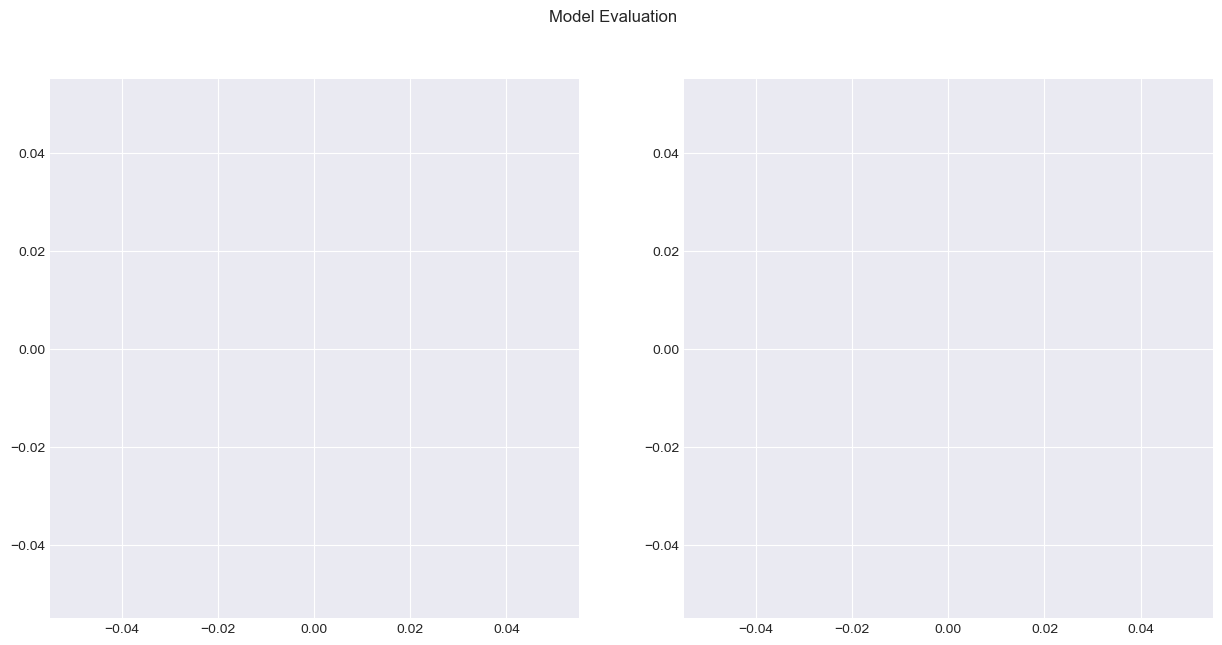

0.008755200768558725 <class 'float'>
tensor(0.0240) <class 'torch.Tensor'>


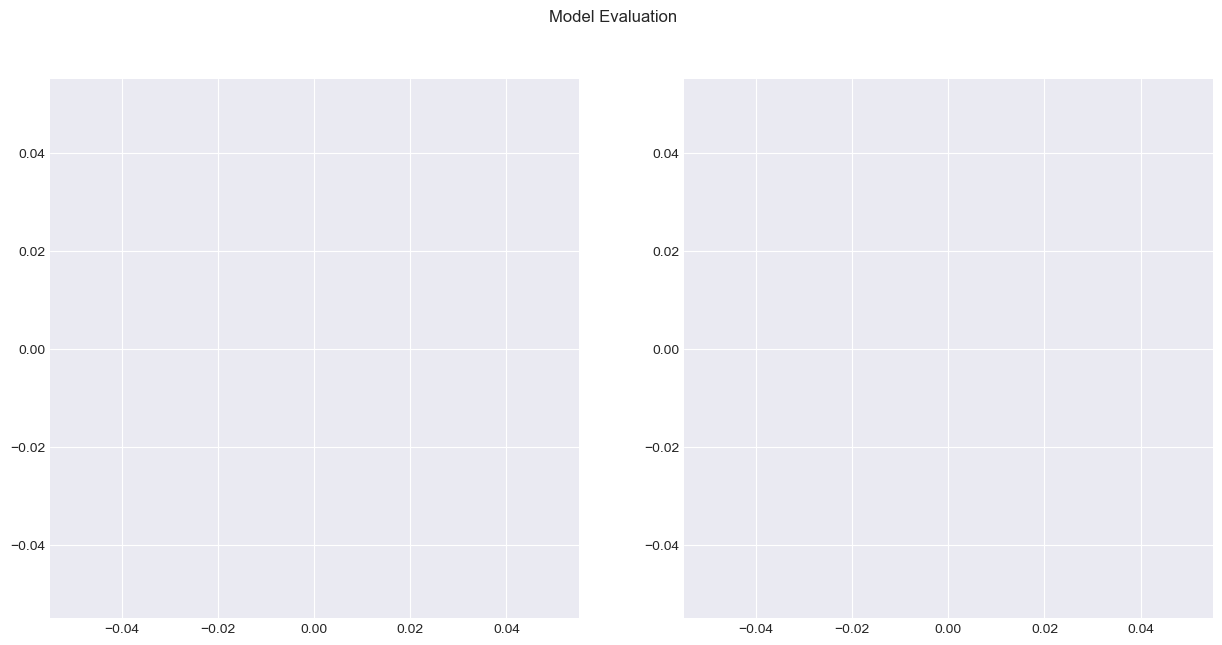

epoch 1 training time: 0m 21s

Epoch 2/20
--------------------------------


Process Process-217:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-3-7de28feeda0d>", line 61, in __getitem__
    images_resized = resize(images_normalized, output_shape=IMAGE_SIZE, mode='reflect', anti_aliasing=True)
  File "/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py", line 144, in resize
    cval=cval, mode=mode)
  File "/anaconda3/lib/python3.6/site-packages/scipy/ndimage/filters.py", line 286, in ga

KeyboardInterrupt: 

Process Process-222:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 184, in default_collate
    return {key: default_collate([d[key] for d in batch]) for key in batch[0]}
  File "/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 184, in <dictcomp>
    return {key: default_collate([d[key] for d in batch]) for key in batch[0]}
  File "/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 164, in default_collate
    return torch.stack(batch, 0, out=out)
KeyboardInterrupt
Process Pro

In [52]:
NUM_EPOCHS = 20
THRESHOLD = 0.5

model = train_model(net=net, 
                    optimizer=optimizer, 
                    criterion=criterion, 
                    scheduler=scheduler, 
                    num_epochs=NUM_EPOCHS, 
                    threshold=THRESHOLD)

In [ ]:
save_network = torch.save(best_net, 'network')

In [ ]:
threshold = 0.036
corrects = 0.0
for i,d in zip(range(1),dataloaders['train']):
    print(d['Images'].shape)
#    d['Images'] = d['Images'][0]
#    d['Targets'] = d['Targets'][0]
    inputs = d['Images']
    labels = d['Targets']
    inputs = inputs.float()
    labels = labels.float()
    print(inputs, labels)
    labels = labels.to(device)
    inputs = inputs.to(device)
    
    outputs = net(inputs)
    #print("outputs.shape:", outputs.shape)
    #print("outputs:", outputs)

    preds = torch.Tensor([1 if pred > 0.5 else 0 for sample in outputs for pred in sample])
    #print(preds.shape)
    labels = torch.reshape(labels, (-1,))
    #print("labels.shape", labels.shape)
    #preds = preds.view(outputs.shape[0], -1)
    #print("preds.shape:", preds.shape)
    #print("preds:", preds)
    
    corrects += torch.sum(torch.Tensor([predicted for predicted, correct in zip(preds, labels) if predicted == correct]))
    #print(corrects)

# To-Do
1. Restrict number of training data. **DONE** *SUCCESS*
2. Batch normalization. **DONE** *SUCCESS*
3. Global Average Pooling instead of Fully Connected layer. **DONE** *FAIL*
4. Google's CoLab (online GPU training). **TOO COMPLICATED**
